In [28]:
!which python 
!whoami 
!hostname
!pwd

/home/farshed.abdukhakimov/miniconda3/envs/main/bin/python
farshed.abdukhakimov
srv-01
/home/farshed.abdukhakimov/projects/root-newton


In [29]:
%load_ext autoreload
%autoreload 2

import datetime
from collections import defaultdict

import numpy as np
import scipy

import matplotlib.pyplot as plt

from dotenv import load_dotenv
load_dotenv()

from utils import plotter
from losses import BaseOracle, PolytopeFeasibility
from methods import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
def plotter(histories, labels, colors=None, linestyles=None, 
            linewidths=None, markers=None, f_star=None, suptitle=None, 
            threshold=1e-10, xlims=None, ylims=None, tight_layout=True, filename=None):
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    if suptitle is not None:
        fig.suptitle(suptitle, fontsize=16)
        
    if colors is None:
        colors = list(plt.cm.colors.XKCD_COLORS.keys())
        np.random.shuffle(colors)
        colors = list(plt.cm.colors.BASE_COLORS) + colors
        
    if linestyles is None:
        linestyles = ["-" for x in histories]
    
    if linewidths is None:
        linewidths = [1.5 for x in histories]
        
    if markers is None:
        markers = [" " for x in histories]
        
    if f_star is None:
        f_star = np.min([x["loss"] for x in histories])
    else:
        f_star = np.min([f_star for x in histories])
    
    for history, label, c, ls, lw, m in zip(histories, labels, colors, linestyles, linewidths, markers):
        f_suboptim = (history["loss"] - f_star) / (history["loss"][0] - f_star)
        
        for i, loss in enumerate(f_suboptim):
            if loss <= threshold:
                history["lr"][i] = 0.0
        
        markevery = [x + np.random.randint(0, 1) for x in range(0, len(history["loss"]), len(history["loss"]) // 10)]
        
        ax[0].semilogy(f_suboptim, linestyle=ls, linewidth=lw, color=c, markevery=markevery, marker=m)
        ax[1].semilogy(history["lr"], linestyle=ls, linewidth=lw, color=c, label=label, markevery=markevery, marker=m)

    if f_star.sum() == 0.0:
        ax[0].set_ylabel(r"$f(x_k)/f(x_0)$")
    else:
        ax[0].set_ylabel(r"$(f(x_k) - f^*)/(f(x_0) - f^*)$")

    ax[1].set_ylabel("step-size")
                
    ax[0].set_xlabel("Steps")
    ax[1].set_xlabel("Steps")
    
    if xlims is not None:
        ax[0].set_xlim(right=xlims[1])
        ax[1].set_xlim(right=xlims[1])
        
    if ylims is not None:
        ax[0].set_ylim(bottom=ylims[0], top=ylims[1])

    fig.legend()
    ax[0].grid()
    ax[1].grid()
    if tight_layout:
        fig.tight_layout()
        
    if filename is not None:
        fig.savefig(filename)
    else:
        fig.show() 

In [32]:
def train_loop(p: int, n_steps: int,
               optimizer: BaseOptimizer, **optimizer_kwargs) -> dict: 
    
    np.random.seed(0)
    
    n = 200
    d = 100
    
    # dataset
    data = np.random.rand(n, d) * 2 - 1
    w_star =  np.random.rand(d) * 2 - 1
    target = data @ w_star
    
    # parameters
    w = np.ones(d)
    optim = optimizer(params=w, **optimizer_kwargs)

    # oracle 
    loss_function = PolytopeFeasibility(data, target, p)
    
    # logging 
    history = defaultdict(list)
    
    start_timestamp = datetime.datetime.now()
        
    for step in range(n_steps):

        time = (datetime.datetime.now() - start_timestamp).total_seconds()

        loss = loss_function.func(w)
        grad = loss_function.grad(w)

        optim.step(oracle=loss_function)

        history["loss"].append(loss)
        history["grad_norm"].append(np.linalg.norm(grad) ** 2)
        history["lr"].append(optim.lr)
    
    return history

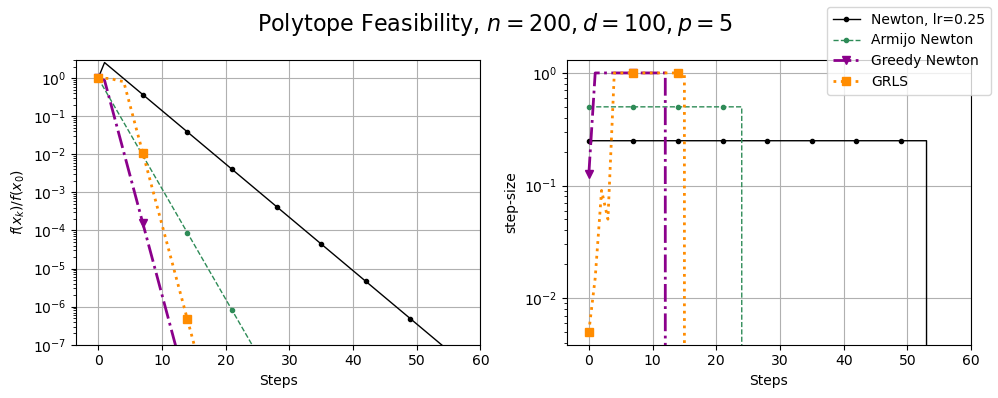

In [52]:
np.random.seed(0)

n_steps = 70

p = 5


histories = []
labels = []

# Damped Newton
hist = train_loop(p=p, n_steps=n_steps+n_steps, optimizer=DampedNewton, lr=0.25)
f_star = hist["loss"][-1]
hist = {key: value[:n_steps] for key, value in hist.items()}
histories.append(hist)
labels.append(r"Newton, lr=0.25")

# Armijo Newton
hist = train_loop(p=p, n_steps=n_steps, optimizer=ArmijoNewton, gamma=0.5, tau=0.1)
lr_arm = hist["lr"]
histories.append(hist)
labels.append(r"Armijo Newton")

# Greedy Newton
hist = train_loop(p=p, n_steps=n_steps, optimizer=GreedyNewton, lr_range=(1e-8, 1.0, 200), verbose=False)
lr_gn = hist["lr"]
histories.append(hist)
labels.append(r"Greedy Newton")

# Line41
hist = train_loop(p=p, n_steps=n_steps, optimizer=Line41, lr_range=(1e-8, 1.0, 200), verbose=False)
lr_41 = hist["lr"]
histories.append(hist)
labels.append("GRLS")

plotter(histories=histories, 
        labels=labels,
        colors=["black", "seagreen", "darkmagenta", "darkorange", "tab:purple"],
        linestyles=["-", "--", "-.", ":", "-"],
        linewidths=[1.0, 1.0, 2.0, 2.0, 1.0],
        markers=[".", ".", "v", "s", "p"],
        suptitle=r"Polytope Feasibility, $n={0}, d={1}, p={2}$".format(200, 100, p),
        threshold=1e-7,
        f_star=0.0,
        ylims=(1e-7, 3.0),
        xlims=(0.0, 60),
        filename=f"plots/polytope_linesearch_p_{p}.pdf")